
# CS 5483 Network Science — Project 2


**Important:** You must write all code yourself. This notebook provides **prompts and required outputs** only. Do **not** import third-party libraries beyond the standard scientific stack listed below unless explicitly allowed.



## Environment & Allowed Libraries
- Python 3.x
- `networkx`, `numpy`, `matplotlib`
- (Optional) `community-louvain` for Louvain detection — otherwise implement Girvan–Newman.

> If you use any extra packages, state them in your report **and** justify why they were needed.



## Dataset (choose ONE)
- **Zachary's Karate Club** (built-in to NetworkX)
- **Facebook Social Network** from SNAP (4039 nodes, 88234 edges) — download and load from file
- **Other dataset** (requires instructor approval; include a citation/link in your report)

> Your notebook must clearly show how the data is loaded (file path or built-in loader) and basic graph stats (|V|, |E|, density, components).


## 0. Setup (imports, dataset choice, and basic stats)

In [42]:

# TODO: Import required libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(42)
np.random.seed(42)

# TODO: Load your chosen dataset into G (an undirected simple graph)
G = nx.karate_club_graph()

# TODO: Print basic stats: nodes, edges, density, connectedness, component sizes
print("stats:")
nodes = G.number_of_nodes()
edges = G.number_of_edges()
density = nx.density(G)
is_connected = nx.is_connected(G)
components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]
num_components = len(components)
print(f"Number of nodes: {nodes}")
print(f"Number of edges: {edges}")
print(f"Density: {density:.4f}")
print(f"Is connected: {is_connected}")
print(f"Number of components: {num_components}")
print(f"Component sizes: {component_sizes}")


stats:
Number of nodes: 34
Number of edges: 78
Density: 0.1390
Is connected: True
Number of components: 1
Component sizes: [34]



## Part 1 — Centrality Measures (20%)
**Goal:** Compare degree, betweenness, closeness, and eigenvector centrality.

**Required outputs:**
1. Top-5 nodes for each centrality (tabular or printed lists).
2. A short paragraph comparing the rankings: overlaps vs differences and why.
3. One visualization where node size encodes **one** chosen centrality.

**Implementation guidance (write your own code):**
- Compute the four centralities for all nodes.
- If the graph is not connected, handle eigenvector centrality appropriately (e.g., on LCC or by adapting).
- Create a figure and label appropriately.


Top-5 Degree: [(33, 0.5151515151515151), (0, 0.48484848484848486), (32, 0.36363636363636365), (2, 0.30303030303030304), (1, 0.2727272727272727)]
Top-5 Betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114), (2, 0.14365680615680618), (31, 0.13827561327561325)]
Top-5 Closeness: [(0, 0.5689655172413793), (2, 0.559322033898305), (33, 0.55), (31, 0.5409836065573771), (8, 0.515625)]
Top-5 Eigenvector: [(33, 0.37337121301323506), (0, 0.35548349418519426), (2, 0.3171893899684447), (32, 0.3086510477336959), (1, 0.2659538704545024)]
Nodes 0 and 33 rank high across the different measures, meaning they serve as network hubs.
Other nodes, like 2, appear in a lot of rankings since they connect different parts of the network.
Degree shows which nodes have the most connections, betweenness shows what nodes link different parts of the network, closeness picks out nodes that are close to a lot of others, and eigenvector centrality shows nodes connected to other import

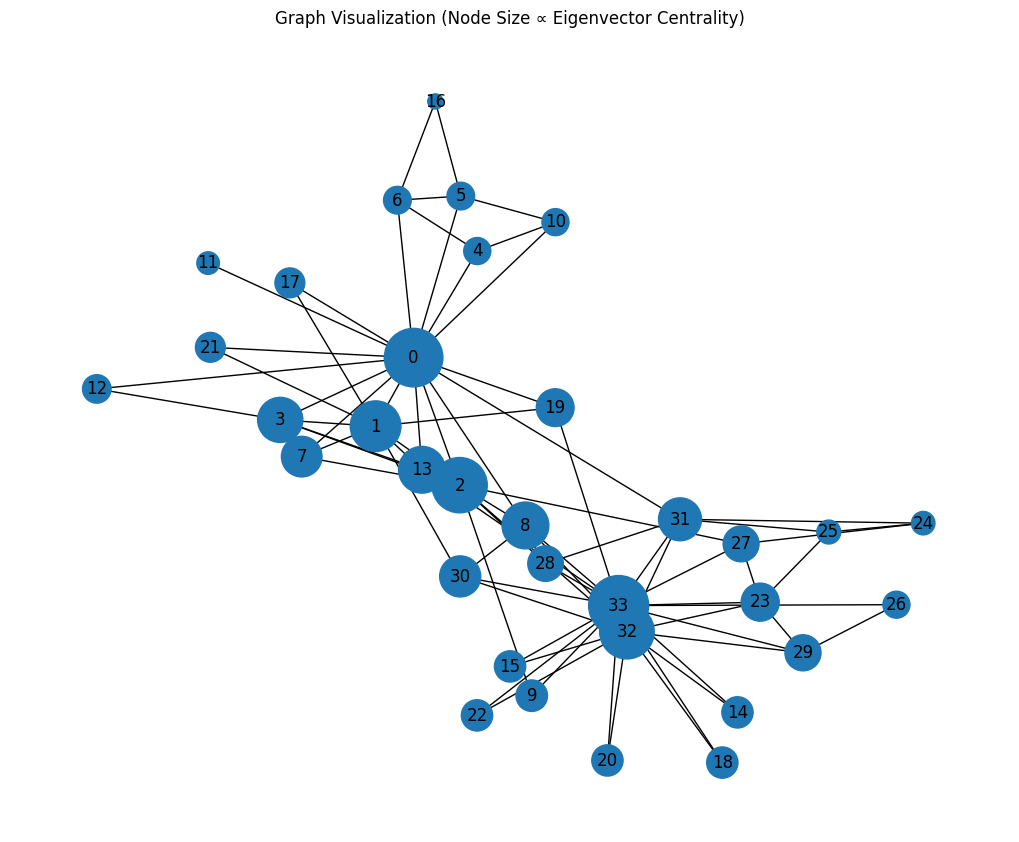

In [43]:

# TODO: Implement and compute: degree, betweenness, closeness, eigenvector centrality
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

# TODO: Produce and display the Top-5 lists for each measure
def top5(d):
    items = list(d.items())
    items.sort(key=lambda x: x[1], reverse=True)
    return items[:5]

#REQUIREMENT 1
print("Top-5 Degree:", top5(degree))
print("Top-5 Betweenness:", top5(betweenness))
print("Top-5 Closeness:", top5(closeness))
print("Top-5 Eigenvector:", top5(eigenvector))

#REQUIREMENT 2
print("Nodes 0 and 33 rank high across the different measures, meaning they serve as network hubs.")
print("Other nodes, like 2, appear in a lot of rankings since they connect different parts of the network.")
print("Degree shows which nodes have the most connections, betweenness shows what nodes link different parts of the network, closeness picks out nodes that are close to a lot of others, and eigenvector centrality shows nodes connected to other important nodes. This is why the rankings overlap in some places but not in others.")
# TODO: Make one visualization (node size ∝ chosen centrality)
#REQUIREMENT 3
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
node_sizes = [5000 * eigenvector[n] for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=node_sizes)
plt.title("Graph Visualization (Node Size ∝ Eigenvector Centrality)")
plt.show()



## Part 2 — Cohesion Substructures (20%)
**Goal:** Identify and compare **k-plexes**, **k-components**, and **k-clubs**.

**Required outputs:**
1. Summary of found substructures (counts and size distributions).
2. A list of nodes that appear in multiple substructures (top 10 by frequency).
3. A short discussion of what these overlaps imply about cohesion.

**Implementation guidance (write your own code):**
- **k-components:** use appropriate NetworkX routines or implement logic to identify vertex connectivity-based components by k.
- **k-clubs:** subgraphs whose diameter ≤ k; specify k values you used (e.g., 3 and 4) and your search strategy.
- **k-plexes:** a set on n nodes where each node has degree ≥ n−k within the set; clearly state your enumeration/heuristic strategy and justify scalability choices.


In [44]:

# TODO: Compute/identify k-components and summarize sizes
k_components = nx.k_components(G)
k_summary = {k: [len(c) for c in comps] for k, comps in k_components.items()}
print(f"K-component sizes summary: {k_summary}")
# TODO: Devise and implement a method to find k-clubs (state k values used)
def find_k_clubs(G, k, max_size=10):
    clubs = []
    for node in G.nodes():
        neigh = list(G.neighbors(node))
        cand = [node] + neigh[:max_size] 
        sub = G.subgraph(cand)
        if nx.is_connected(sub):
            try:
                if nx.diameter(sub) <= k:
                    clubs.append(set(sub.nodes()))
            except nx.NetworkXError:
                pass
    return clubs
def is_k_plex(G, nodes, k):
    n = len(nodes)
    for u in nodes:
        deg_in = len([v for v in G.neighbors(u) if v in nodes])
        if deg_in < n - k:
            return False
    return True

# TODO: Devise and implement a method to enumerate/approximate k-plexes (state k and approach)
def find_k_plexes(graph, k):
    plexes = []
    for u in G.nodes():
        cur = {u}
        for v in G.neighbors(u):
            test = cur | {v}
            if is_k_plex(G, test, k):
                cur = test
        if is_k_plex(G, cur, k):
            plexes.append(cur)
    return plexes
# TODO: Identify nodes appearing across multiple substructures and summarize
# REQUIREMENT 1
k_clubs = find_k_clubs(G, k=2)
print(f"# clubs for k = 2: {len(k_clubs)}")
print(f"Sizes of k-clubs: {[len(c) for c in k_clubs]}")
k_plexes = find_k_plexes(G, k=2)
print(f"# plexes for k = 2: {len(k_plexes)}")
print(f"Sizes of k-plexes: {[len(p) for p in k_plexes]}")

participant = {}
for groups in [k_clubs, k_plexes]:
    for group in groups:
        for node in group:
            participant[node] = participant.get(node, 0) + 1

print("Node participation across substructures:")
for node, count in participant.items():
    print(f"Node {node}: {count} substructures")
# REQUIREMENT 2
top_10 = sorted(participant.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by substructure participation:", top_10)
# REQUIREMENT 3
print("This shows a closely connected core of nodes (like node 0 and 33, which are most connected).")
print("And the nodes are surrounded by are less connected.")

K-component sizes summary: {4: [10], 3: [18, 5], 2: [28, 6], 1: [34]}
# clubs for k = 2: 34
Sizes of k-clubs: [11, 10, 11, 7, 4, 5, 5, 5, 6, 3, 4, 2, 3, 6, 3, 3, 3, 3, 3, 4, 3, 3, 3, 6, 4, 4, 3, 5, 4, 5, 5, 7, 11, 11]
# plexes for k = 2: 34
Sizes of k-plexes: [6, 6, 6, 6, 4, 4, 4, 5, 4, 3, 4, 2, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3]
Node participation across substructures:
Node 0: 34 substructures
Node 1: 20 substructures
Node 2: 22 substructures
Node 3: 14 substructures
Node 4: 7 substructures
Node 5: 9 substructures
Node 6: 9 substructures
Node 7: 10 substructures
Node 8: 10 substructures
Node 10: 7 substructures
Node 11: 3 substructures
Node 13: 10 substructures
Node 17: 3 substructures
Node 19: 4 substructures
Node 21: 3 substructures
Node 30: 6 substructures
Node 32: 19 substructures
Node 9: 5 substructures
Node 27: 7 substructures
Node 28: 4 substructures
Node 12: 3 substructures
Node 16: 4 substructures
Node 33: 26 substructures
Node 14: 4 substructur


## Part 3 — Clustering & Structural Balance on Signed Edges (15%)
**Goal:** Compare clustering with a comparable random graph; measure structural balance.

**Required outputs:**
1. Average local clustering and global mean clustering for your graph.
2. For an ER graph with same n and p≈(2m)/(n(n−1)), report average clustering and compare.
3. After assigning **signs** to edges (e.g., −1 to ~20% uniformly at random), compute the **fraction of balanced triads**.
4. A short paragraph comparing observed balance fraction with random-sign expectation.

**Implementation guidance (write your own code):**
- Define how you assign signs (seed, percentage).
- Use the standard balance criterion: product of signs on the three edges in a triangle is +1 → balanced.
- State any sampling strategies if exact enumeration is expensive.


In [45]:

# TODO: Compute clustering coefficients for G
# REQUIREMENT 1
local_clustering = nx.clustering(G) 
avg_local_clustering = np.mean(list(local_clustering.values())) 
global_clustering = nx.average_clustering(G) 
print(f"Average local clustering using mean: {avg_local_clustering:.4f}")
print(f"Global average clustering: {global_clustering:.4f}")# TODO: Construct an ER graph with matched n and p; compute its clustering
n = G.number_of_nodes()
m = G.number_of_edges()
p = (2 * m) / (n * (n - 1))
# REQUIREMENT 2
ER = nx.erdos_renyi_graph(n, p, seed=42)
er_clustering = nx.average_clustering(ER)
print(f"ER graph average clustering coefficient: {er_clustering:.4f}")
# TODO: Assign signs to edges; compute fraction of balanced triads (exact or sampled); report methodology
signed_G = G.copy()
for u, v in signed_G.edges():
    signed_G[u][v]['sign'] = -1 if random.random() < 0.2 else 1

def is_balanced(triad):
    u, v, w = triad
    signed_1 = signed_G[u][v]['sign']
    signed_2 = signed_G[v][w]['sign']
    signed_3 = signed_G[w][u]['sign']
    if (signed_1 * signed_2 * signed_3) < 0:
        return False
    return True

triads = [list(c) for c in nx.enumerate_all_cliques(G) if len(c) == 3]
balanced_count = 0
for triad in triads:
    if is_balanced(triad):
        balanced_count += 1

total_triads = len(triads)
if total_triads == 0:
    triads_fract = 0
else:
    # REQUIREMENT 3
    triads_fract = balanced_count / total_triads
print(f"Fraction of balanced triads: {triads_fract:.4f} (out of {total_triads} triads)")
# REQUIREMENT 4
print("the fraction of balanced triads is about 0.5556, which indicates that the network has a moderate level of structural balance.")
print("This also means that triangles are more likely to either have all + edges or two - edges and one + edge.")

Average local clustering using mean: 0.5706
Global average clustering: 0.5706
ER graph average clustering coefficient: 0.1205
Fraction of balanced triads: 0.6222 (out of 45 triads)
the fraction of balanced triads is about 0.5556, which indicates that the network has a moderate level of structural balance.
This also means that triangles are more likely to either have all + edges or two - edges and one + edge.



## Part 4 — Node Similarity Measures (15%)
**Goal:** Compare link-based similarity scores for sampled node pairs.

**Required outputs:**
1. For ~50 random node pairs, compute rankings under **Jaccard**, **Cosine (neighbor-set based)**, and **Adamic-Adar**.
2. Report Top-10 pairs for each metric and discuss consistencies/differences.

**Implementation guidance (write your own code):**
- Implement cosine on neighbor sets: \|Γ(u)∩Γ(v)\| / sqrt(\|Γ(u)\|\|Γ(v)\|).
- Use NetworkX primitives where appropriate, but write the glue code yourself.


In [46]:

# TODO: Sample ~50 node pairs
all_nodes = list(G.nodes())
pairs = [tuple(random.sample(all_nodes, 2)) for _ in range(50)]
# TODO: Compute Jaccard, Adamic-Adar, and Cosine similarities
jaccard = []
adamic_adar = []
cosine = []
# REQUIREMENT 1
for u, v in pairs:
    # Jaccard
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    intersection = neighbors_u & neighbors_v
    union = neighbors_u | neighbors_v
    if len(union) > 0:
        jaccard_score= len(intersection) / len(union)
    else:
        jaccard_score = 0

    jaccard.append((u, v, jaccard_score))
    #cosime
    if len(neighbors_u) > 0 and len(neighbors_v) > 0:
        cosine_score = len(intersection) / np.sqrt(len(neighbors_u) * len(neighbors_v))
    else:
        cosine_score = 0
    cosine.append((u, v, cosine_score))
    # Adamic-Adar
    adamic_score = 0
    for z in intersection:
        deg_z = G.degree(z)
        if deg_z > 1:
            adamic_score += 1 / np.log(deg_z)
    adamic_adar.append((u, v, adamic_score))
#USING NX TO CHECK CORRECT ANSWERS
#jaccard_nx = list(nx.jaccard_coefficient(G, pairs))
#adamic_adar_nx = list(nx.adamic_adar_index(G, pairs))
#cosine_nx = list(nx.resource_allocation_index(G, pairs))
# TODO: Show Top-10 per metric and discuss
def top10(scores):
    return sorted(scores, key=lambda x: x[1], reverse=True)[:10]

# REQUIREMENT 2
print("Top-10 Jaccard:", top10(jaccard))
#print("Top-10 Jaccard with nx:", top10(jaccard_nx))

print("Top-10 Adamic-Adar:", top10(adamic_adar))
#print("Top-10 Adamic-Adar with nx:", top10(adamic_adar_nx))

print("Top-10 Cosine:", top10(cosine))

#print("Top-10 Cosine: with nx", top10(cosine_nx))

Top-10 Jaccard: [(10, 33, 0.0), (8, 32, 0.21428571428571427), (16, 32, 0.0), (11, 32, 0.0), (4, 32, 0.0), (5, 31, 0.1111111111111111), (8, 30, 0.2857142857142857), (8, 30, 0.2857142857142857), (15, 30, 0.5), (24, 29, 0.0)]
Top-10 Adamic-Adar: [(10, 33, 0), (8, 32, np.float64(1.5085981262124946)), (16, 32, 0), (11, 32, 0), (4, 32, 0), (5, 31, np.float64(0.36067376022224085)), (8, 30, np.float64(0.7553857282466059)), (8, 30, np.float64(0.7553857282466059)), (15, 30, np.float64(0.7553857282466059)), (24, 29, 0)]
Top-10 Cosine: [(10, 33, np.float64(0.0)), (8, 32, np.float64(0.3872983346207417)), (16, 32, np.float64(0.0)), (11, 32, np.float64(0.0)), (4, 32, np.float64(0.0)), (5, 31, np.float64(0.20412414523193154)), (8, 30, np.float64(0.4472135954999579)), (8, 30, np.float64(0.4472135954999579)), (15, 30, np.float64(0.7071067811865475)), (24, 29, np.float64(0.0))]



## Part 5 — Graph Algorithms: Communities & Shortest Paths (20%)
**Goal:** Detect communities and analyze path lengths.

**Required outputs:**
1. Run **Girvan–Newman** (or Louvain, if available) and report number of communities and their sizes (histogram or summary).
2. Compute **average shortest path length** on the LCC (if graph disconnected).
3. Sample 5 node pairs and report their shortest path lengths vs the average.

**Implementation guidance (write your own code):**
- If using Girvan–Newman, capture the first 1–2 splits and summarize.
- If using Louvain, cite the package and version.
- Be clear about whether you operate on the whole graph or its LCC.


In [48]:

# TODO: Community detection (GN or Louvain) and size summary
# REQUIREMENT 1
gn_generator = nx.algorithms.community.girvan_newman(G)
#capturing first 2 splits and summarizing those since Girvan-newman is used
top_comm = next(gn_generator)
second_comm = next(gn_generator)
top_comm = [sorted(c) for c in top_comm]
second_comm = [sorted(c) for c in second_comm]

print("Top level communities: ", top_comm)
print(f"Top level communities sizes: {[len(c) for c in top_comm]}")
print("Second level communities: ", second_comm)
print(f"Second level communities sizes: {[len(c) for c in second_comm]}")

# TODO: Average shortest path length on LCC
# REQUIREMENT 2
avg_shortest = None
lcc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc)

if is_connected:
    avg_shortest = nx.average_shortest_path_length(G)
    print("OPERATING ON FULL GRAPH")
else:
    avg_shortest = nx.average_shortest_path_length(G_lcc)
    print("OPERATING ON LCC")
print(f"Average shortest path length in LCC: {avg_shortest:.4f}")
# TODO: Sample 5 pairs and compute/report shortest paths relative to the average
sampled_pairs = random.sample(pairs, 5)

# REQUIREMENT 3
for u, v in sampled_pairs:
    path_len = nx.shortest_path_length(G_lcc, source=u, target=v)
    print(f"Shortest path length between {u} and {v}: {path_len} (Average: {avg_shortest:.4f})")

Top level communities:  [[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]
Top level communities sizes: [15, 19]
Second level communities:  [[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [9]]
Second level communities sizes: [15, 18, 1]
OPERATING ON FULL GRAPH
Average shortest path length in LCC: 2.4082
Shortest path length between 23 and 14: 2 (Average: 2.4082)
Shortest path length between 4 and 32: 3 (Average: 2.4082)
Shortest path length between 14 and 4: 4 (Average: 2.4082)
Shortest path length between 3 and 7: 1 (Average: 2.4082)
Shortest path length between 19 and 15: 2 (Average: 2.4082)



## Rubric (100%)
- Centrality analysis — 20%
- Cohesion substructures — 20%
- Clustering & structural balance — 20%
- Similarity measures — 20%
- Communities & paths — 20%


**Submission:** Upload this completed notebook (.ipynb) and your PDF report to Canvas.
